## Subgroup Analysis

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(gridExtra)))
suppressWarnings(suppressMessages(library(memisc)))
library(emmeans)

# Load the data
load(file = "~/Documents/vcf/data/moderation.RData")
paste0("Initial sample: ", nrow(vcf_data))

[1] "Initial sample: 371"

### PHI Trust Views

In [2]:
subgroup_ANCOVA <- function(subgroup, label, pad = 0){
    
    # ANCOVA using a Box-Cox Transformation
    get_emm_diff_bc <- function(data, label, method = "ml"){
    # fit base model    
    base_model <- aov(post ~ group + wave + 
                      republican + conservative + 
                      employment2 + education2 + marital_status + gender + age + income2 +                     
                      pre, data = data)
     
    # calculate Box-Cox lambda
    bc <- trafo::boxcox(base_model, method = method, lambdarange = c(-10, 3), plotit = FALSE)
    lambda <- bc$lambdahat
    bctrans <- make.tran("boxcox", lambda)
  
    # fit model to transformed data    
    model <- with(bctrans,
              aov(linkfun(post) ~ group + wave + 
                                  republican + conservative +  
                                  employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))           
    
    # plot estimated marginal means
    emm_back <- emmeans(model, "group", type = "response")    
    
    # calculate differences in expected marginal means
    rg <- ref_grid(model, "group")
    emm_diff_back <- pairs(emmeans(regrid(rg, transform = "response"), "group"))    
    
    # calculate 95% CI for difference in expected marginal means
    ci <- emm_diff_back %>% confint()    
    
    # assemble results
    mean <- ci$estimate
    low <- ci$lower.CL
    high <- ci$upper.CL
    p <- summary(emm_diff_back)$p.value
    ci_summary <- paste0("mean = ", round(mean, 3), 
                         "; 95% CI = ", round(low, 3), ", ", round(high, 3), 
                         "; P = ", round(p, 4))
    plot_points <- tibble(x = c(low, mean, high), label = label)
        
    return(list(
        "base_model" = base_model,        
        "model" = model,
        "emm_back" = emm_back,        
        "emm_diff_back" = emm_diff_back,
        "CI" = ci_summary,
        "plot_points" = plot_points))}
    
    
    intention <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = intention_6_n, pre = base_intention_n),   
                                 method = "ml", label = "intention")

    encourage <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = encourage_6_n, pre = base_encourage_n),   
                                 method = "ml", label = "encourage")

    sp_confidence <- get_emm_diff_bc(data = subgroup %>% 
                                     dplyr::mutate(post = sp_confidence_6_n, pre = base_sp_confidence_n),   
                                     method = "ml", label = "sp_confidence")

    sp_complacency <- get_emm_diff_bc(data = subgroup %>% 
                                      dplyr::mutate(post = sp_complacency_6_n, pre = base_sp_complacency_n),   
                                      method = "ml", label = "sp_complacency")
   
    plot_df <- bind_rows(intention$plot_points %>% mutate(y = 4),
                     encourage$plot_points %>% mutate(y = 3),                 
                     sp_confidence$plot_points %>% mutate(y = 2),                     
                     sp_complacency$plot_points %>% mutate(y = 1))                                                             
    
    plot_df_means <- plot_df[seq(2, nrow(plot_df), by = 3),]
    labels <- plot_df$label %>% unique()
    breaks <- plot_df$y %>% unique()
    
    plot <- ggplot(data = plot_df,
           mapping = aes(x = x, y = y)) +
      geom_line(data = plot_df,
                mapping = aes(x = x, y = y, group = label, color = "purple")) +
      geom_point(data = plot_df_means,
                 mapping = aes(x = x, y = y, group = label, color = "purple"), 
                 shape = 18, size = 3) +
      theme_minimal() +
        scale_color_manual(values = "#6F55AA") + # purple      
        scale_y_continuous(
          breaks = breaks,
          labels = labels) +
        labs(
          x = "",
          y = " ",
          title = label) +
        geom_vline(xintercept =  0, color = "black") +
        theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.y = element_text(size = 10)
        ) +
        theme(panel.border=element_rect(linetype=1,fill=NA)) +
        guides(color = "none") +
        theme(plot.title = element_text(hjust = 0.5)) +
      xlim(-0.6 - pad, 0.6 + pad)
    
    tbl <- bind_rows(
      tibble(measure = "Intentions to Vaccinate", CI = intention$CI),
      tibble(measure = "Intentions to Encourage Others to Vaccinate", CI = encourage$CI),
      tibble(measure = "COVID-19 Vaccine Confidence", CI = sp_confidence$CI),
      tibble(measure = "COVID-19 Vaccine Complacency", CI = sp_complacency$CI)) %>%
      mutate(print = paste0(measure, " (", CI, ")")) %>%.$print 
    
    return(list("plot_df" = plot_df,
                "plot" = plot, 
                "tbl" = tbl,
                "intention" = intention,
                "encourage" = encourage,
                "sp_confidence" = sp_confidence,
                "sp_complacency" = sp_complacency                
               ))
    }

In [3]:
vcf_data %>% group_by(phi_trust_cat) %>% count()

phi_trust_cat,n
<fct>,<int>
distrusting,119
trusting,252


In [4]:
phi_distrust <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(phi_trust_cat == "distrusting"), 
                label = "a) Distrusting", pad = 0.6)

phi_trust <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(phi_trust_cat == "trusting"), 
                label = "b) Trusting", pad = 0.6)

phi_distrust$tbl
phi_trust$tbl

[1] "Intentions to Vaccinate (mean = -0.005; 95% CI = -0.037, 0.027; P = 0.7501)"                   
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.006; 95% CI = -0.063, 0.074; P = 0.8717)"
[3] "COVID-19 Vaccine Confidence (mean = -0.199; 95% CI = -0.456, 0.059; P = 0.1292)"               
[4] "COVID-19 Vaccine Complacency (mean = 0.006; 95% CI = -0.225, 0.237; P = 0.9582)"

[1] "Intentions to Vaccinate (mean = 0.423; 95% CI = 0.114, 0.732; P = 0.0075)"                   
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.488; 95% CI = 0.126, 0.85; P = 0.0084)"
[3] "COVID-19 Vaccine Confidence (mean = 0.22; 95% CI = 0.003, 0.436; P = 0.0467)"                
[4] "COVID-19 Vaccine Complacency (mean = 0.13; 95% CI = -0.105, 0.365; P = 0.2761)"

### Governmental Institution Trust Views

In [5]:
vcf_data %>% group_by(gov_trust_cat) %>% count()

gov_trust_cat,n
<fct>,<int>
distrusting,177
trusting,194


In [6]:
gov_distrust <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(gov_trust_cat == "distrusting"), 
                label = "Distrusting", pad = 0.6)

gov_trust <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(gov_trust_cat == "trusting"), 
                label = "Trusting", pad = 0.6)

gov_distrust$tbl
gov_trust$tbl

[1] "Intentions to Vaccinate (mean = 0.053; 95% CI = -0.01, 0.116; P = 0.0969)"                    
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.149; 95% CI = 0.018, 0.281; P = 0.0262)"
[3] "COVID-19 Vaccine Confidence (mean = -0.045; 95% CI = -0.229, 0.14; P = 0.6326)"               
[4] "COVID-19 Vaccine Complacency (mean = 0.036; 95% CI = -0.177, 0.248; P = 0.7404)"

[1] "Intentions to Vaccinate (mean = 0.287; 95% CI = -0.124, 0.699; P = 0.1704)"                   
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.267; 95% CI = -0.207, 0.74; P = 0.2681)"
[3] "COVID-19 Vaccine Confidence (mean = 0.177; 95% CI = -0.096, 0.451; P = 0.2016)"               
[4] "COVID-19 Vaccine Complacency (mean = 0.125; 95% CI = -0.158, 0.407; P = 0.3863)"

### Party Affiliation

In [7]:
subgroup_ANCOVA <- function(subgroup, label, pad = 0){
    
    # ANCOVA using a Box-Cox Transformation
    get_emm_diff_bc <- function(data, label, method = "ml"){
    # fit base model    
    base_model <- aov(post ~ group + wave + 
                      conservative + phi_trust_cat +
                      employment2 + education2 + marital_status + gender + age + income2 +                     
                      pre, data = data)
     
    # calculate Box-Cox lambda
    bc <- trafo::boxcox(base_model, method = method, lambdarange = c(-10, 3), plotit = FALSE)
    lambda <- bc$lambdahat
    bctrans <- make.tran("boxcox", lambda)
  
    # fit model to transformed data    
    model <- with(bctrans,
              aov(linkfun(post) ~ group + wave + 
                                  conservative + phi_trust_cat +
                                  employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))           
    
    # plot estimated marginal means
    emm_back <- emmeans(model, "group", type = "response")    
    
    # calculate differences in expected marginal means
    rg <- ref_grid(model, "group")
    emm_diff_back <- pairs(emmeans(regrid(rg, transform = "response"), "group"))    
    
    # calculate 95% CI for difference in expected marginal means
    ci <- emm_diff_back %>% confint()    
    
    # assemble results
    mean <- ci$estimate
    low <- ci$lower.CL
    high <- ci$upper.CL
    p <- summary(emm_diff_back)$p.value
    ci_summary <- paste0("mean = ", round(mean, 3), 
                         "; 95% CI = ", round(low, 3), ", ", round(high, 3), 
                         "; P = ", round(p, 4))
    plot_points <- tibble(x = c(low, mean, high), label = label)
        
    return(list(
        "base_model" = base_model,        
        "model" = model,
        "emm_back" = emm_back,        
        "emm_diff_back" = emm_diff_back,
        "CI" = ci_summary,
        "plot_points" = plot_points))}
    
    
    intention <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = intention_6_n, pre = base_intention_n),   
                                 method = "ml", label = "intention")

    encourage <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = encourage_6_n, pre = base_encourage_n),   
                                 method = "ml", label = "encourage")

    sp_confidence <- get_emm_diff_bc(data = subgroup %>% 
                                     dplyr::mutate(post = sp_confidence_6_n, pre = base_sp_confidence_n),   
                                     method = "ml", label = "sp_confidence")

    sp_complacency <- get_emm_diff_bc(data = subgroup %>% 
                                      dplyr::mutate(post = sp_complacency_6_n, pre = base_sp_complacency_n),   
                                      method = "ml", label = "sp_complacency")
   
    plot_df <- bind_rows(intention$plot_points %>% mutate(y = 4),
                     encourage$plot_points %>% mutate(y = 3),                  
                     sp_confidence$plot_points %>% mutate(y = 2),                     
                     sp_complacency$plot_points %>% mutate(y = 1))                                                             
    
    plot_df_means <- plot_df[seq(2, nrow(plot_df), by = 3),]
    labels <- plot_df$label %>% unique()
    breaks <- plot_df$y %>% unique()
    
    plot <- ggplot(data = plot_df,
           mapping = aes(x = x, y = y)) +
      geom_line(data = plot_df,
                mapping = aes(x = x, y = y, group = label, color = "purple")) +
      geom_point(data = plot_df_means,
                 mapping = aes(x = x, y = y, group = label, color = "purple"), 
                 shape = 18, size = 3) +
      theme_minimal() +
        scale_color_manual(values = "#6F55AA") + # purple      
        scale_y_continuous(
          breaks = breaks,
          labels = labels) +
        labs(
          x = "",
          y = " ",
          title = label) +
        geom_vline(xintercept =  0, color = "black") +
        theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.y = element_text(size = 10)
        ) +
        theme(panel.border=element_rect(linetype=1,fill=NA)) +
        guides(color = "none") +
        theme(plot.title = element_text(hjust = 0.5)) +
      xlim(-0.6 - pad, 0.6 + pad)
    
    tbl <- bind_rows(
      tibble(measure = "Intentions to Vaccinate", CI = intention$CI),
      tibble(measure = "Intentions to Encourage Others to Vaccinate", CI = encourage$CI),
      tibble(measure = "COVID-19 Vaccine Confidence", CI = sp_confidence$CI),
      tibble(measure = "COVID-19 Vaccine Complacency", CI = sp_complacency$CI)) %>%
      mutate(print = paste0(measure, " (", CI, ")")) %>%.$print 
    
    return(list("plot_df" = plot_df,
                "plot" = plot, 
                "tbl" = tbl,
                "intention" = intention,
                "encourage" = encourage,
                "sp_confidence" = sp_confidence,
                "sp_complacency" = sp_complacency                
               ))
    }

In [8]:
vcf_data %>% group_by(republican) %>% count()

republican,n
<fct>,<int>
rep,147
nonrep,224


In [9]:
rep <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(republican == "rep"), 
                label = "a) Republican", pad = 0.6)

non_rep <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(republican != "rep"), 
                label = "b) Non-Republican", pad = 0.6)

rep$tbl
non_rep$tbl

[1] "Intentions to Vaccinate (mean = 0.139; 95% CI = -0.049, 0.326; P = 0.1462)"                   
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.211; 95% CI = 0.031, 0.391; P = 0.0221)"
[3] "COVID-19 Vaccine Confidence (mean = 0.088; 95% CI = -0.166, 0.343; P = 0.4939)"               
[4] "COVID-19 Vaccine Complacency (mean = 0.153; 95% CI = -0.14, 0.446; P = 0.3032)"

[1] "Intentions to Vaccinate (mean = 0.15; 95% CI = -0.111, 0.41; P = 0.2582)"                      
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.138; 95% CI = -0.204, 0.479; P = 0.4278)"
[3] "COVID-19 Vaccine Confidence (mean = -0.001; 95% CI = -0.212, 0.21; P = 0.994)"                 
[4] "COVID-19 Vaccine Complacency (mean = 0.042; 95% CI = -0.174, 0.257; P = 0.703)"

### Political Views

In [10]:
subgroup_ANCOVA <- function(subgroup, label, pad = 0){
    
    # ANCOVA using a Box-Cox Transformation
    get_emm_diff_bc <- function(data, label, method = "ml"){
    # fit base model    
    base_model <- aov(post ~ group + wave + 
                      republican + phi_trust_cat +
                      employment2 + education2 + marital_status + gender + age + income2 +                     
                      pre, data = data)
     
    # calculate Box-Cox lambda
    bc <- trafo::boxcox(base_model, method = method, lambdarange = c(-10, 3), plotit = FALSE)
    lambda <- bc$lambdahat
    bctrans <- make.tran("boxcox", lambda)
  
    # fit model to transformed data    
    model <- with(bctrans,
              aov(linkfun(post) ~ group + wave + 
                                  republican + phi_trust_cat +
                                  employment2 + education2 + marital_status + gender + age + income2 +                     
                                  linkfun(pre), data = data))           
    
    # plot estimated marginal means
    emm_back <- emmeans(model, "group", type = "response")    
    
    # calculate differences in expected marginal means
    rg <- ref_grid(model, "group")
    emm_diff_back <- pairs(emmeans(regrid(rg, transform = "response"), "group"))    
    
    # calculate 95% CI for difference in expected marginal means
    ci <- emm_diff_back %>% confint()    
    
    # assemble results
    mean <- ci$estimate
    low <- ci$lower.CL
    high <- ci$upper.CL
    p <- summary(emm_diff_back)$p.value
    ci_summary <- paste0("mean = ", round(mean, 3), 
                         "; 95% CI = ", round(low, 3), ", ", round(high, 3), 
                         "; P = ", round(p, 4))
    plot_points <- tibble(x = c(low, mean, high), label = label)
        
    return(list(
        "base_model" = base_model,        
        "model" = model,
        "emm_back" = emm_back,        
        "emm_diff_back" = emm_diff_back,
        "CI" = ci_summary,
        "plot_points" = plot_points))}
    
    
    intention <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = intention_6_n, pre = base_intention_n),   
                                 method = "ml", label = "intention")

    encourage <- get_emm_diff_bc(data = subgroup %>% dplyr::mutate(post = encourage_6_n, pre = base_encourage_n),   
                                 method = "ml", label = "encourage")

    sp_confidence <- get_emm_diff_bc(data = subgroup %>% 
                                     dplyr::mutate(post = sp_confidence_6_n, pre = base_sp_confidence_n),   
                                     method = "ml", label = "sp_confidence")

    sp_complacency <- get_emm_diff_bc(data = subgroup %>% 
                                      dplyr::mutate(post = sp_complacency_6_n, pre = base_sp_complacency_n),   
                                      method = "ml", label = "sp_complacency")
   
    plot_df <- bind_rows(intention$plot_points %>% mutate(y = 4),
                     encourage$plot_points %>% mutate(y = 3),                      
                     sp_confidence$plot_points %>% mutate(y = 2),                     
                     sp_complacency$plot_points %>% mutate(y = 1))                                                             
    
    plot_df_means <- plot_df[seq(2, nrow(plot_df), by = 3),]
    labels <- plot_df$label %>% unique()
    breaks <- plot_df$y %>% unique()
    
    plot <- ggplot(data = plot_df,
           mapping = aes(x = x, y = y)) +
      geom_line(data = plot_df,
                mapping = aes(x = x, y = y, group = label, color = "purple")) +
      geom_point(data = plot_df_means,
                 mapping = aes(x = x, y = y, group = label, color = "purple"), 
                 shape = 18, size = 3) +
      theme_minimal() +
        scale_color_manual(values = "#6F55AA") + # purple      
        scale_y_continuous(
          breaks = breaks,
          labels = labels) +
        labs(
          x = "",
          y = " ",
          title = label) +
        geom_vline(xintercept =  0, color = "black") +
        theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.y = element_text(size = 10)
        ) +
        theme(panel.border=element_rect(linetype=1,fill=NA)) +
        guides(color = "none") +
        theme(plot.title = element_text(hjust = 0.5)) +
      xlim(-0.6 - pad, 0.6 + pad)
    
    tbl <- bind_rows(
      tibble(measure = "Intentions to Vaccinate", CI = intention$CI),
      tibble(measure = "Intentions to Encourage Others to Vaccinate", CI = encourage$CI),
      tibble(measure = "COVID-19 Vaccine Confidence", CI = sp_confidence$CI),
      tibble(measure = "COVID-19 Vaccine Complacency", CI = sp_complacency$CI)) %>%
      mutate(print = paste0(measure, " (", CI, ")")) %>%.$print 
    
    return(list("plot_df" = plot_df,
                "plot" = plot, 
                "tbl" = tbl,
                "intention" = intention,
                "encourage" = encourage,
                "sp_confidence" = sp_confidence,
                "sp_complacency" = sp_complacency                
               ))
    }

In [11]:
vcf_data %>% group_by(conservative) %>% count()

conservative,n
<fct>,<int>
nonconserv,203
conserv,168


In [12]:
conserv <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(conservative == "conserv"), 
                label = "Conservative", pad = 0.6)

non_conserv <- subgroup_ANCOVA(subgroup = vcf_data %>% filter(conservative != "conserv"), 
                label = "Non-Conservative", pad = 0.6)

conserv$tbl
non_conserv$tbl

[1] "Intentions to Vaccinate (mean = 0.051; 95% CI = -0.055, 0.156; P = 0.3459)"                   
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.225; 95% CI = 0.042, 0.407; P = 0.0163)"
[3] "COVID-19 Vaccine Confidence (mean = 0.086; 95% CI = -0.115, 0.286; P = 0.4013)"               
[4] "COVID-19 Vaccine Complacency (mean = 0.125; 95% CI = -0.083, 0.333; P = 0.2376)"

[1] "Intentions to Vaccinate (mean = 0.257; 95% CI = -0.055, 0.569; P = 0.106)"                     
[2] "Intentions to Encourage Others to Vaccinate (mean = 0.098; 95% CI = -0.269, 0.465; P = 0.5973)"
[3] "COVID-19 Vaccine Confidence (mean = -0.011; 95% CI = -0.254, 0.231; P = 0.9256)"               
[4] "COVID-19 Vaccine Complacency (mean = 0.021; 95% CI = -0.221, 0.263; P = 0.8652)"

### Summary Plots

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


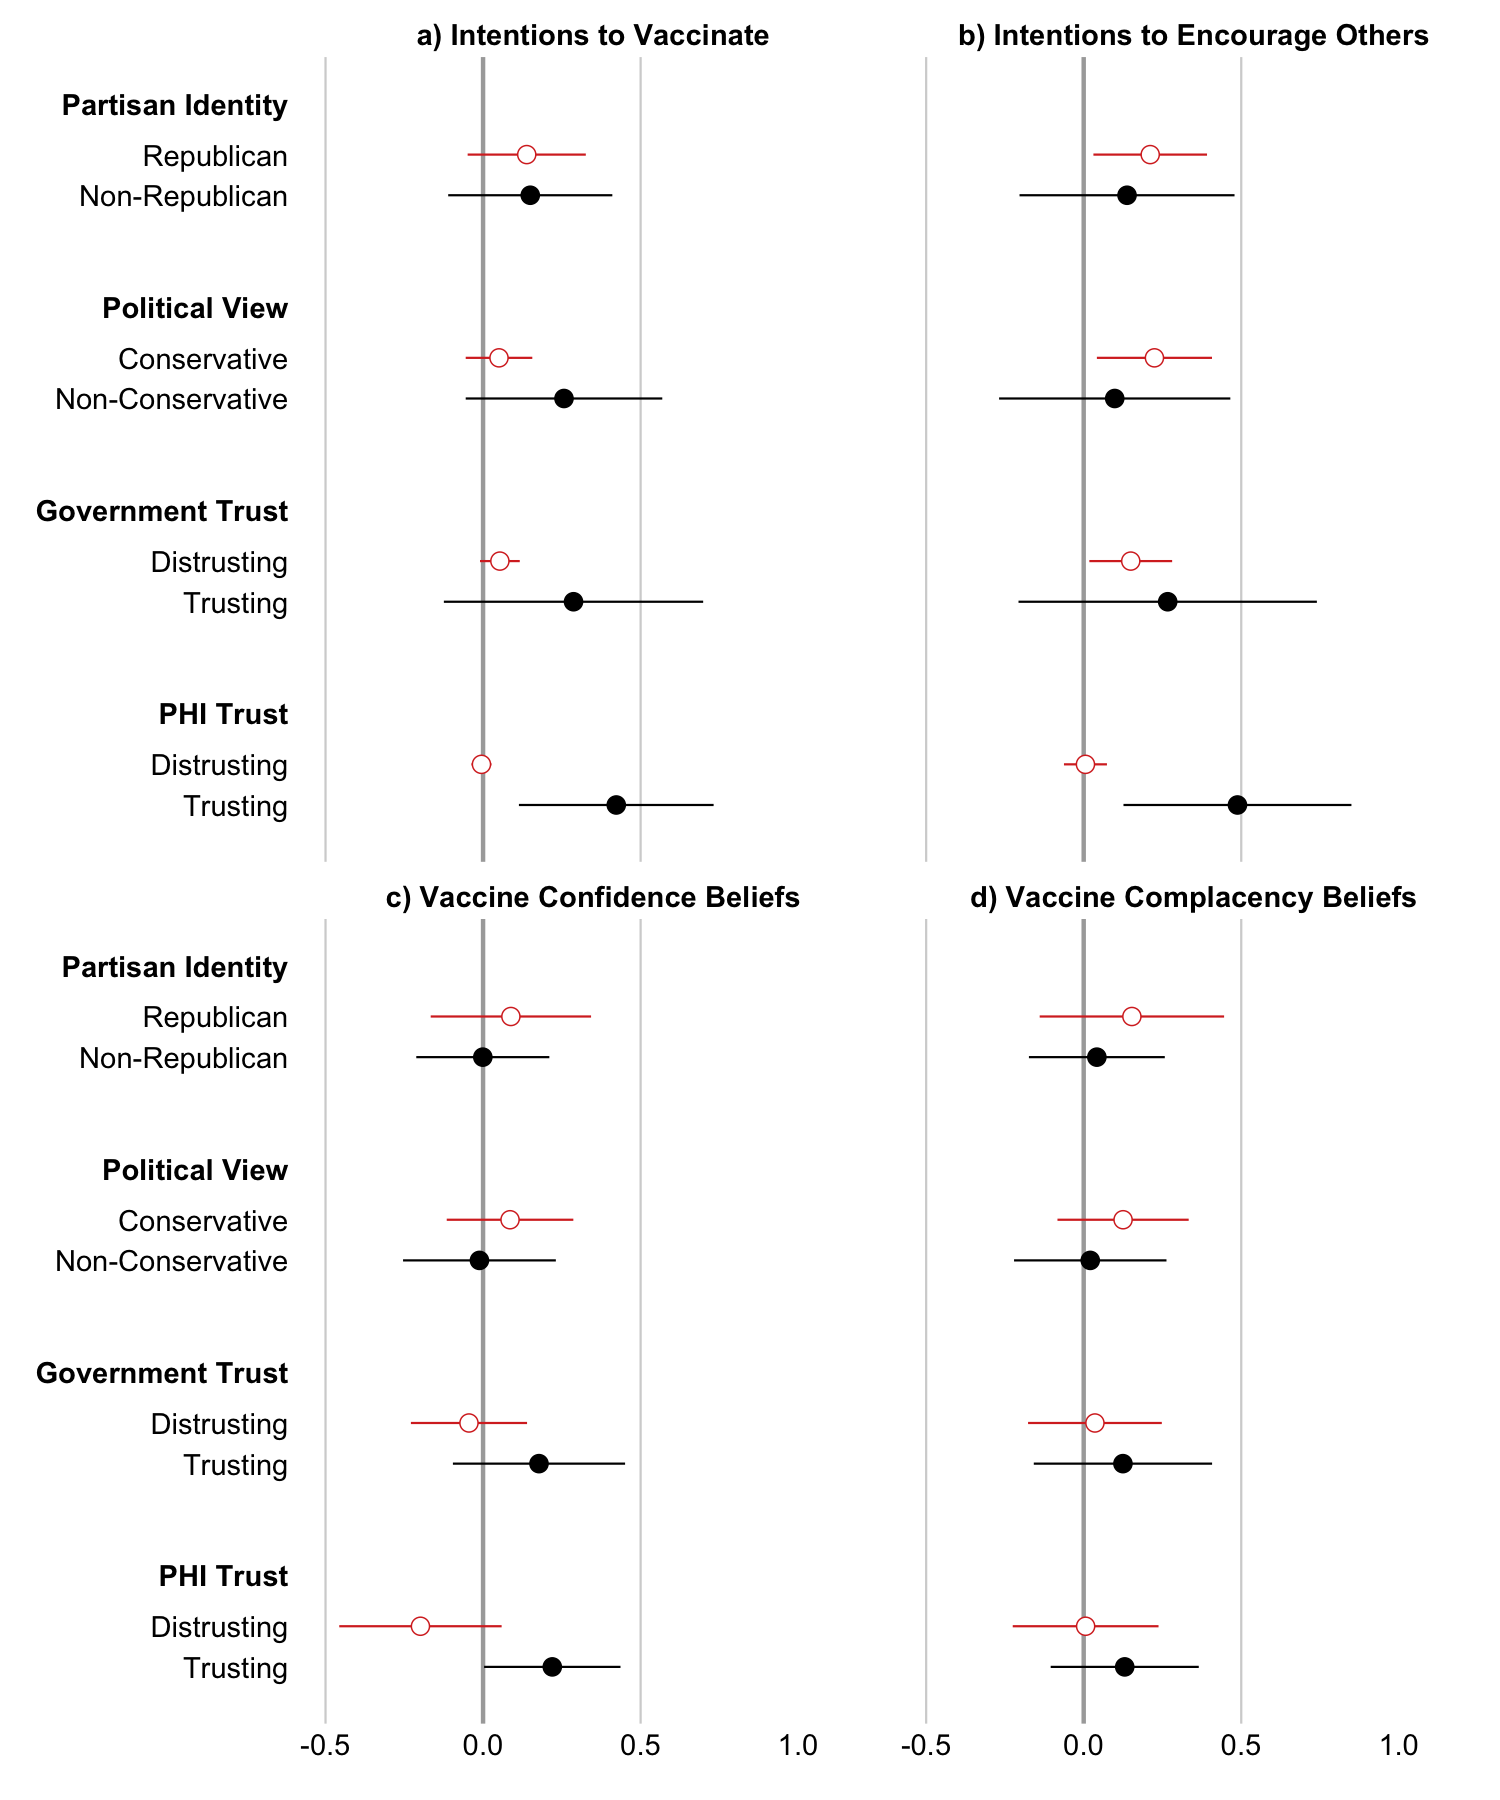

In [13]:
plot_df <- bind_rows(rep$plot_df %>% mutate(y = 4.2, subgroup = "Republican", color = "red"),
                     non_rep$plot_df %>% mutate(y = 4, subgroup = "Non-Republican", color = "black"),
                     conserv$plot_df %>% mutate(y = 3.2, subgroup = "Conservative", color = "red"),
                     non_conserv$plot_df %>% mutate(y = 3, subgroup = "Non-Conservative", color = "black"),
                     gov_distrust$plot_df %>% mutate(y = 2.2, subgroup = "Govt. Distrusting", color = "red"),
                     gov_trust$plot_df %>% mutate(y = 2, subgroup = "Govt. Trusting", color = "black"),
                     phi_distrust$plot_df %>% mutate(y = 1.2, subgroup = "PHI Distrusting", color = "red"),
                     phi_trust$plot_df %>% mutate(y = 1, subgroup = "PHI Trust", color = "black"),
                    )

plot_df$label[plot_df$label == "intention"] <- "a) Intentions to Vaccinate"
plot_df$label[plot_df$label == "encourage"] <- "b) Intentions to Encourage Others"
plot_df$label[plot_df$label == "sp_confidence"] <- "c) Vaccine Confidence Beliefs"
plot_df$label[plot_df$label == "sp_complacency"] <- "d) Vaccine Complacency Beliefs"
plot_df$label <- factor(plot_df$label, 
                        levels = c("a) Intentions to Vaccinate",
                                   "b) Intentions to Encourage Others",
                                   "c) Vaccine Confidence Beliefs",
                                   "d) Vaccine Complacency Beliefs"))

plot_df_means <- plot_df[seq(2, nrow(plot_df), by = 3),]

options(repr.plot.width = 10, repr.plot.height = 12, repr.plot.res = 150)
ggplot(data = plot_df,
       mapping = aes(x = x, y = y, group = subgroup, color = color)) +
    geom_vline(xintercept =  0, color = "darkgray", size = 1) +
    geom_vline(xintercept =  -0.5, color = "lightgray") +
    geom_vline(xintercept =  0.5, color = "lightgray") +
    geom_line() +
    geom_point(data = plot_df_means %>% filter(color == "red"),
                 mapping = aes(x = x, y = y, group = label), 
                 shape = 21, size = 3.75,  fill = "white") +
    
    geom_point(data = plot_df_means %>% filter(color == "black"),
                 mapping = aes(x = x, y = y, group = label), 
                 shape = 21, size = 3.75, fill = "black") +    
    facet_wrap(~label, ncol = 2)  +
    theme_minimal() + 
    scale_color_manual(values = c("black", "#d73027")) + 
    scale_fill_manual(values = c("#4575b4", "#d73027")) + 
    scale_y_continuous(
        breaks = c(4.45, 4.2, 4,
                   3.45, 3.2, 3,
                   2.45, 2.2, 2,
                   1.45, 1.2, 1
        ),
        labels = c("Partisan Identity", "Republican", "Non-Republican",
                   "Political View", "Conservative", "Non-Conservative",
                   "Government Trust", "Distrusting", "Trusting", 
                   "PHI Trust", "Distrusting", "Trusting"
                   ),
        limits = c(0.9, 4.5)) +
    labs(y = "", x = "") + 
    theme( 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.x = element_text(size = 14, color= "black"),
          axis.text.y = element_text(face = c(#'bold',
                                              'bold', 'plain', 'plain',
                                              'bold', 'plain', 'plain', 
                                              'bold', 'plain', 'plain',
                                              'bold', 'plain', 'plain',
                                              'bold', 'plain', 'plain'),
                                     size = 14, color = "black"),
          strip.text.x = element_text(size = 14, face = "bold", colour = "black")
        ) +
    #theme(panel.border=element_rect(linetype=1,fill=NA)) +
    guides(color = "none") +
    theme(plot.title = element_text(hjust = 0.5)) +
    xlim(-0.5, 1.2) 

#ggsave(filename = "/Users/dankoban/Documents/trust_partisanship/mod_plot.tiff", width = 10, height = 12, device='tiff', dpi=800)
